In [1]:
%load_ext autoreload
%autoreload 2

from collections import defaultdict
from itertools import product
from dataclasses import dataclass
import os
import math
import sys
from typing import Dict, Any, List, Optional
sys.path.append('../../../../')

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import numpy as np
import pandas as pd

from matplotlib.ticker import FuncFormatter


from multitask_nlp.utils.plotting import Task, get_overall_score

color_pallette = 'muted'
sns.set_theme(style='whitegrid', context='talk', palette=color_pallette, 
              rc={'font.family': 'serif', 'font.serif': 'Times New Roman', 'mathtext.fontset': 'dejavuserif'})

tasks = [
    Task(name='PolEval18_POS', measure='accuracy_pos', 
         measure_name='Accuracy', size=25267)
]

cols_to_display = ['dataset', 'learning_kind', 'model_name', 'model_type', 'type', 'overall_score']

In [2]:
def get_type(row):
    ttype = row['learning_kind']
    return ttype

def load_results_df(file_path: str):
    df = pd.read_csv(file_path)
    df['type'] = df.apply(lambda x: get_type(x), axis=1)
    df['overall_score'] = df.apply(lambda x: get_overall_score(x, tasks=tasks), axis=1)
    return df

In [4]:
def visualize_boxplot_paper(
    df: pd.DataFrame, legend_labels: Optional[List[str]] = None, cols=2,
    suptitle: str = '', bbox_to_anchor = (1.0, 1.0), loc=2, ncol=1, fig_legend=True,
    order=None, steps=True, runtimes=True, epochs=False, **kwargs
):  
    row_height = 5
    fig_width = 14
    
    additional_plots_prop = []
    if runtimes:
        additional_plots_prop.append(('Runtime', 'Runtime [s]'))
    if steps:
        additional_plots_prop.append(('trainer/global_step', 'Steps'))
    if epochs:
        additional_plots_prop.append(('epoch', 'Epochs'))
        
    rows = math.ceil((len(tasks) * (1+len(additional_plots_prop))) / cols)
    
    if order is None:
        types = df['type'].unique()
        types = sorted(types, key=len)
    else:
        types = order
    
    x_ticks_labels = []
    for t in types:
        split_t_string = t.split('_')
        t_string = split_t_string[0]
        if len(split_t_string) > 1:
            t_string += '\n' + '\n'.join(split_t_string[1:])
        x_ticks_labels.append(t_string)

    fig, axis = plt.subplots(rows, cols, figsize=(fig_width, rows*row_height), constrained_layout=True)
    if rows * cols == 1:
        axis = [axis]
    else:
        axis = axis.flatten()
                
    for task, ax in zip(tasks, axis):
        sns.boxplot(x='type', y=f'{task.name}_test_{task.measure}', order=types, ax=ax, data=df, **kwargs)
        ax.set_xticklabels(x_ticks_labels)           
        ax.set_xlabel(None)
        ax.set_ylabel(task.measure_name)
        
        title = task.name + ' - ' + human_format(task.size)       
        ax.set_title(title)
        
        handles, labels = ax.get_legend_handles_labels()
        if ax.get_legend():
            legend_title = ax.get_legend().get_title().get_text().replace('_', ' ').capitalize()
            ax.get_legend().remove()
            if not fig_legend:
                ax.legend(handles, labels, title=legend_title, bbox_to_anchor=bbox_to_anchor, loc=loc, ncol=ncol)


    if fig_legend and len(handles) > 0: 
        fig.legend(handles, labels, title=legend_title, bbox_to_anchor=bbox_to_anchor, loc=loc, ncol=ncol)
        
    if 'hue' in kwargs:
        hue = kwargs['hue']
    else:
        hue = None
        
    if 'hue_order' in kwargs:
        hue_order = kwargs['hue_order']
    else:
        hue_order = None
    
    for i, (column_name, ylabel) in enumerate(additional_plots_prop):
                
        for task, ax in zip(tasks, axis[len(tasks) * (1+i):]):
            displ_df = df.dropna(subset=['dataset'])
            displ_df = displ_df[displ_df['dataset'].str.contains(task.name)]
            sns.barplot(x='type', y=column_name, order=types, ax=ax, data=displ_df, edgecolor='black', 
                        hue=hue, hue_order=hue_order)
            ax.set_xticklabels(x_ticks_labels)   
            ax.set_ylabel(ylabel)
            ax.set_xlabel(None)
            title = task.name + ' - ' + human_format(task.size)       
            ax.set_title(title)
            
            handles, labels = ax.get_legend_handles_labels()
            if ax.get_legend():
                legend_title = ax.get_legend().get_title().get_text().replace('_', ' ').capitalize()
                ax.get_legend().remove()
                if not fig_legend:
                    ax.legend(handles, labels, title=legend_title, bbox_to_anchor=bbox_to_anchor, loc=loc, ncol=ncol)

        if fig_legend and len(handles) > 0: 
            fig.legend(handles, labels, title=legend_title, bbox_to_anchor=bbox_to_anchor, loc=loc, ncol=ncol)  

#     for ax in axis[len(tasks):]:
#         ax.axis('off')    
    sns.despine(fig)

def human_format(num):
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    # add more suffixes if you need them
    return '%.1f%s' % (num, ['', 'K', 'M', 'G', 'T', 'P'][magnitude])

In [5]:
def get_model_kind(r):
    kind = r['model_name']        
    return kind

# Eksperymenty 1

- Powtórzenia: 3
- Liczba Epok: 8
- Learning rate: 1e-4
- Max length: 256
- Batch size: 32

In [6]:
df = load_results_df('stl_pos_poleval18_results.csv')
df['model_kind'] = df.apply(lambda r: get_model_kind(r), axis=1)

In [7]:
# df

In [8]:
# with pd.option_context('display.max_rows', None):
#     display(df[cols_to_display + ['model_kind']])
# with pd.option_context('display.max_rows', None):
#     display(df[['dataset', 'type', 'scale_class_loss', 'epoch', 'num_epochs', 'trainer/global_step', 'Runtime']])
df['model_kind'].unique()
df['model_kind'].value_counts()

polish-roberta          3
polish-distilroberta    3
Name: model_kind, dtype: int64

In [9]:
# df.columns.values

In [10]:
df['type'].unique()

array(['STL'], dtype=object)

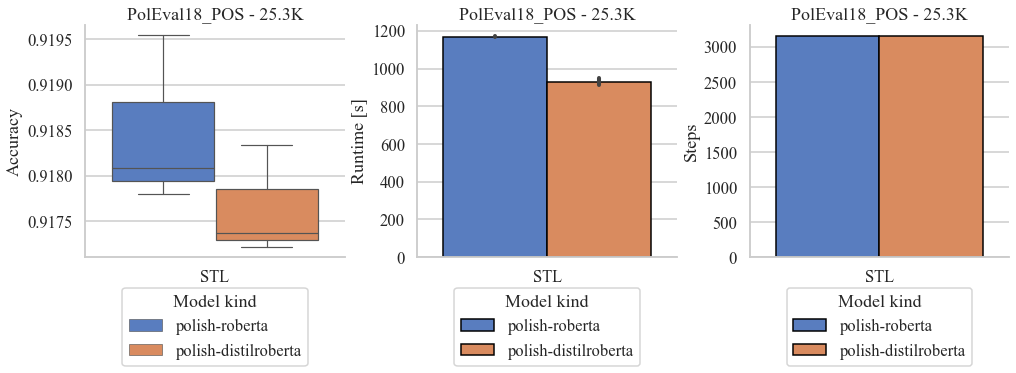

In [11]:
hue_order = ['polish-roberta', 'polish-distilroberta']
visualize_boxplot_paper(
    df, cols=3,
    showfliers=True, linewidth=1.2,
    hue='model_kind', 
    hue_order=hue_order,
    ncol=1, loc='center', bbox_to_anchor=(0.5, -0.3), fig_legend=False,
    runtimes=True, steps=True 
)